In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import sklearn

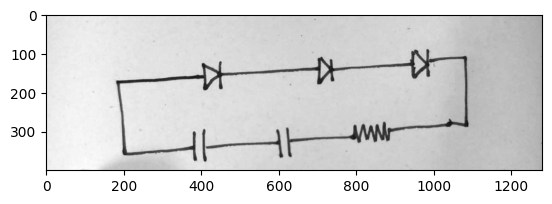

In [87]:
img = cv2.imread('test_images/test8.jpeg')
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(grey_img, cmap='gray')

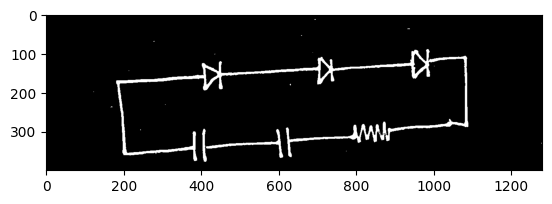

In [88]:
th = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 21)
plt.imshow(th, cmap='gray')

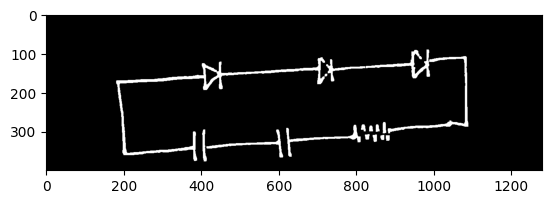

In [89]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening_img = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=2)
plt.imshow(opening_img, cmap='gray')

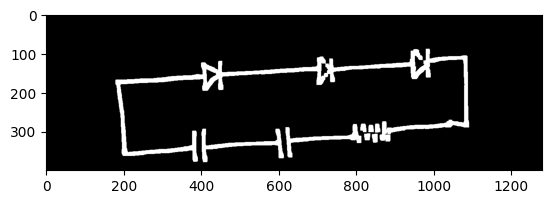

In [90]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
dline = cv2.dilate(opening_img, kernel, iterations=2)
plt.imshow(dline, cmap='gray')

(10, 200, 90)
(129, 1, 230)
(201, 96, 177)
(15, 202, 120)
(240, 196, 189)
(19, 183, 64)


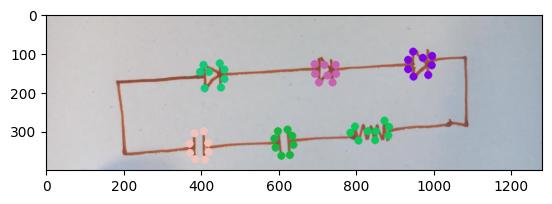

In [91]:
anchor_points = cv2.goodFeaturesToTrack(image=dline,maxCorners=100,qualityLevel=0.40,minDistance=20, blockSize=15)

# Convert the anchor points to a numpy array
anchor_points = np.float32(anchor_points.reshape((-1, 2)))

# Perform DBSCAN clustering on the anchor points
clustering = DBSCAN(eps=80, min_samples=4).fit(anchor_points)

# Get the labels for the clusters
labels = clustering.labels_

# Find the unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)

# Draw circles around the points in the cluster with the highest count
img2 = img.copy()
for l in unique_labels:
    if l == -1: continue
    px = [int(i[0]) for i in anchor_points[labels == l]]
    py = [int(i[1]) for i in anchor_points[labels == l]]
    color = np.random.choice(range(256), size=3)
    color = (int (color [ 0 ]), int (color [ 1 ]), int (color [ 2 ]))
    print(color)
    for i in range(len(px)):
        cv2.circle(img2, (px[i], py[i]), 5, color=tuple(color), thickness=10)
    
plt.imshow(img2)
plt.show()

In [92]:
# Calculate the mean coordinates of each cluster
cluster_centers = []
for label in unique_labels:
    if label == -1:
        continue
    cluster_points = anchor_points[labels == label]
    cluster_center = np.mean(cluster_points, axis=0)
    cluster_centers.append(cluster_center)

print(cluster_centers)

[array([839.8889 , 301.33334], dtype=float32), array([964. , 127.5], dtype=float32), array([721.125, 150.125], dtype=float32), array([431.375, 154.75 ], dtype=float32), array([395.375, 340.125], dtype=float32), array([613.875, 328.5  ], dtype=float32)]


In [93]:
#fast = cv2.FastFeatureDetector_create()
fast = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=False, type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
kp = fast.detect(dline, None)

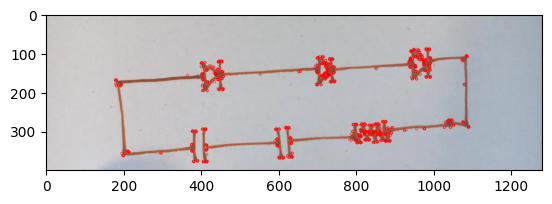

In [94]:
img4 = img.copy()
img4 = cv2.drawKeypoints(img4, kp, None, color=(255,0,0))
plt.imshow(img4)
plt.show()

In [95]:
fast_features = [np.array([int(kp[i].pt[0]), int(kp[i].pt[1])]) for i in range(len(kp))]
clustering = DBSCAN(eps=60, min_samples=30).fit(fast_features)
labels_fast = clustering.labels_

In [96]:
final_keypoints = anchor_points.copy()
final_labels = labels.copy()

for i in fast_features:
    for j in range(len(cluster_centers)):
        if np.linalg.norm(i-cluster_centers[j]) < 60:
            final_keypoints = np.vstack((final_keypoints, [i]))
            final_labels = np.append(final_labels, unique_labels[j+1])
            break

(54, 62, 201)
(241, 22, 154)
(138, 113, 226)
(157, 238, 144)
(139, 167, 202)
(134, 2, 79)


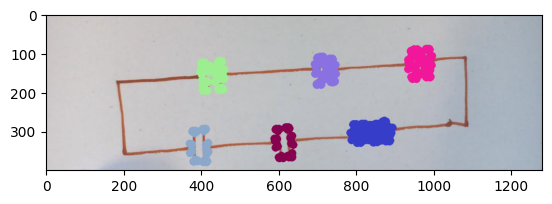

In [97]:
img3 = img.copy()
for l in unique_labels:
    if l == -1: continue
    px = [int(i[0]) for i in final_keypoints[final_labels == l]]
    py = [int(i[1]) for i in final_keypoints[final_labels == l]]
    color = np.random.choice(range(256), size=3)
    color = (int (color [ 0 ]), int (color [ 1 ]), int (color [ 2 ]))
    print(color)
    for i in range(len(px)):
        cv2.circle(img3, (px[i], py[i]), 5, color=tuple(color), thickness=10)
    
plt.imshow(img3)
plt.show()

In [98]:
remove_comp = dline.copy()
rects = []
rects_contour = []
components_extracted = []


for l,_ in enumerate(counts):
    if l == 0: continue
    px = [int(i[0]) for i in final_keypoints[final_labels == unique_labels[l]]]
    py = [int(i[1]) for i in final_keypoints[final_labels == unique_labels[l]]]
    if abs(max(py)-min(py))*abs(max(px)-min(px)) > 700:
        components_extracted.append(dline[min(py)-15:max(py)+15, min(px)-15:max(px)+15])
        remove_comp[min(py)-15:max(py)+15, min(px)-15:max(px)+15] = 0    
        rects_contour.append((np.array([[min(px)-15, min(py)-15],[max(px)+15, min(py)-15],[max(px)+15, max(py)+15],[min(px)-15, max(py)+15]])))
        rects.append([min(px)-22,max(px)+22,min(py)-22,max(py)+22])

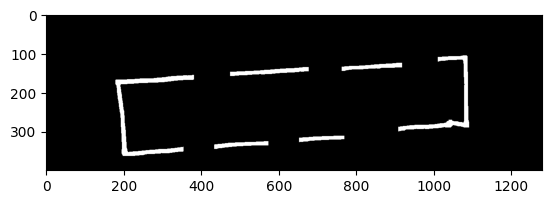

In [99]:
plt.imshow(remove_comp, cmap='gray')

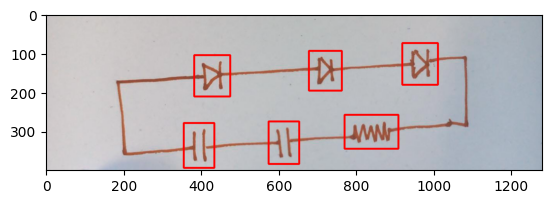

In [100]:
img2 = img.copy()
plt.imshow(cv2.drawContours(img2, tuple(rects_contour), -1, (255,0,0), 3))

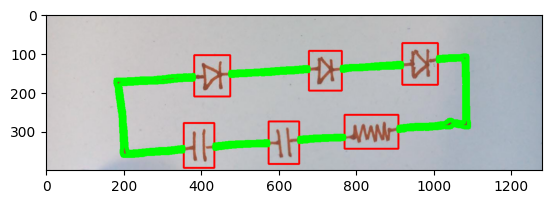

In [101]:
cnts = cv2.findContours(remove_comp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_cnts = [c for c in cnts[0] if cv2.contourArea(c) > 600]

wiring_dict = {}
last_key = 0
for c in filtered_cnts:
    for rect in rects:
        for p in c:
            # rect[0] is xmin, rect[1] is xmax, rect[2] is ymin, rect[3] is ymax
            # p[0][0] is x, p[0][1] is y
            if p[0][0] >= rect[0] and p[0][0] <= rect[1] and p[0][1] >= rect[2] and p[0][1] <= rect[3]:
                if last_key not in wiring_dict.keys():
                    wiring_dict[last_key] = [rect]
                else:
                    wiring_dict[last_key].append(rect)
                break
    last_key += 1

key = 0
dict_len = len(wiring_dict)
del_wire = []
while key < dict_len:
    if len(wiring_dict[key]) == 1:
        del_wire.append(key)
        del wiring_dict[key]
    key += 1

for i in del_wire:
    del filtered_cnts[i]

cv2.drawContours(img, tuple(rects_contour), -1, (255,0,0), 3)
cv2.drawContours(img, filtered_cnts, -1, (0,255,0), 10)
plt.imshow(img)

In [102]:
wiring_dict

{0: [[348, 441, 272, 401], [567, 660, 268, 391]],
 1: [[763, 916, 251, 352], [567, 660, 268, 391]],
 2: [[375, 482, 98, 218], [348, 441, 272, 401]],
 3: [[671, 770, 87, 203], [375, 482, 98, 218]],
 4: [[912, 1018, 67, 188], [671, 770, 87, 203]],
 5: [[763, 916, 251, 352], [912, 1018, 67, 188]]}